In [501]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

1. Скачайте датасет House Prices Kaggle со страницы конкурса (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) и сохраните его в том же каталоге, что и ваш скрипт или блокнот Python.

Описания файлов
* train.csv — обучающий набор
* test.csv — набор тестов
* data_description.txt — полное описание каждого столбца, первоначально подготовленное Дином Де Коком, но слегка отредактированное, чтобы соответствовать именам столбцов, использованным здесь.
* sample_submission.csv — эталонное представление, полученное на основе линейной регрессии по году и месяцу продажи, площади участка и количеству спален

Используем обчающий набор данных

2. Загрузите датасет в pandas DataFrame под названием df.

In [502]:
df = pd.read_csv('house-prices-advanced-regression-techniques\\train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [503]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

3. Выполните предварительную обработку данных, выполнив следующие шаги: <br>
a. Определите и обработайте отсутствующие значения в датасете. Определите, в каких столбцах есть отсутствующие значения, и решите, как их обработать (например, заполнить средним, медианой или модой, или отбросить столбцы/строки с существенными отсутствующими значениями). <br>b. Проверьте и обработайте любые дублирующиеся строки в датасете. c. Проанализируйте типы данных в каждом столбце и при необходимости преобразуйте их (например, из объектных в числовые типы).

In [504]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [505]:
df.loc[:, df.columns[df.isna().any()]].isna().sum()


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [506]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 81 columns and 1460 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PoolQC,0,1453,99.5,1453,99.5,object
MiscFeature,0,1406,96.3,1406,96.3,object
Alley,0,1369,93.8,1369,93.8,object
Fence,0,1179,80.8,1179,80.8,object
MasVnrType,0,872,59.7,872,59.7,object
FireplaceQu,0,690,47.3,690,47.3,object
LotFrontage,0,259,17.7,259,17.7,float64
GarageType,0,81,5.5,81,5.5,object
GarageYrBlt,0,81,5.5,81,5.5,float64
GarageFinish,0,81,5.5,81,5.5,object


В таблице представлены: <br> Нулевые значения,<br>
Пропущенные значения <br>
% от общего количества значений <br>
Всего пропущенных значений ноль <br>
% Всего ноль пропущенных значений <br>
Тип данных

In [507]:
df.columns[df.isnull().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [508]:
# Данные типа float64 из таблицы с отсутствующими значениями 
# заменим на среднее значение
df[['LotFrontage', 'MasVnrArea']] = df[['LotFrontage', 'MasVnrArea']].fillna(df[['LotFrontage', 'MasVnrArea']].mean())

In [509]:
df.groupby(['GarageYrBlt']).agg({'Id': ['count']})

,Id
,count
GarageYrBlt,
1900.0,1
1906.0,1
1908.0,1
1910.0,3
1914.0,2
...,...
2006.0,59
2007.0,49


In [510]:
# год постройки GarageYrBlt float64 заменим на среднее значение  

# mean_GarageYrBlt = df['GarageYrBlt'].mean()
# df['GarageYrBlt'] = df['GarageYrBlt'].fillna(median_GarageYrBlt)
# df['GarageYrBlt']

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

In [511]:
# Удаляем столбцы, где менее 1000 непропущенных значений, то есть пропущенных не более 460
df2 = df.dropna(axis = 1, thresh = 1000)

In [512]:
missing_zero_values_table(df2)

Your selected dataframe has 75 columns and 1460 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
GarageType,0,81,5.5,81,5.5,object
GarageFinish,0,81,5.5,81,5.5,object
GarageQual,0,81,5.5,81,5.5,object
GarageCond,0,81,5.5,81,5.5,object
BsmtExposure,0,38,2.6,38,2.6,object
BsmtFinType2,0,38,2.6,38,2.6,object
BsmtQual,0,37,2.5,37,2.5,object
BsmtCond,0,37,2.5,37,2.5,object
BsmtFinType1,0,37,2.5,37,2.5,object
Electrical,0,1,0.1,1,0.1,object


In [513]:
for column in df2.columns:
    df2[column].fillna('NaN')

In [514]:
missing_zero_values_table(df2)

Your selected dataframe has 75 columns and 1460 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
GarageType,0,81,5.5,81,5.5,object
GarageFinish,0,81,5.5,81,5.5,object
GarageQual,0,81,5.5,81,5.5,object
GarageCond,0,81,5.5,81,5.5,object
BsmtExposure,0,38,2.6,38,2.6,object
BsmtFinType2,0,38,2.6,38,2.6,object
BsmtQual,0,37,2.5,37,2.5,object
BsmtCond,0,37,2.5,37,2.5,object
BsmtFinType1,0,37,2.5,37,2.5,object
Electrical,0,1,0.1,1,0.1,object


In [515]:
# Строки не дублируются
duplicates = df2.duplicated()
print('duplicated rows: ')

duplicated rows: 


4. Проведите разведочный анализ данных (EDA), ответив на следующие вопросы: <br> a. Каково распределение целевой переменной 'SalePrice'? Есть ли какие-либо выбросы? <br>b. Исследуйте взаимосвязи между целевой переменной и другими характеристиками. Есть ли сильные корреляции?<br> c. Исследуйте распределение и взаимосвязи других важных характеристик, таких как 'OverallQual', 'GrLivArea', 'GarageCars' и т.д. d. Визуализируйте данные, используя соответствующие графики (например, гистограммы, диаграммы рассеяния, квадратные диаграммы), чтобы получить представление о датасете.

In [516]:
df2['SalePrice'].describe().round(1)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

Text(0, 0.5, 'Количество домов')

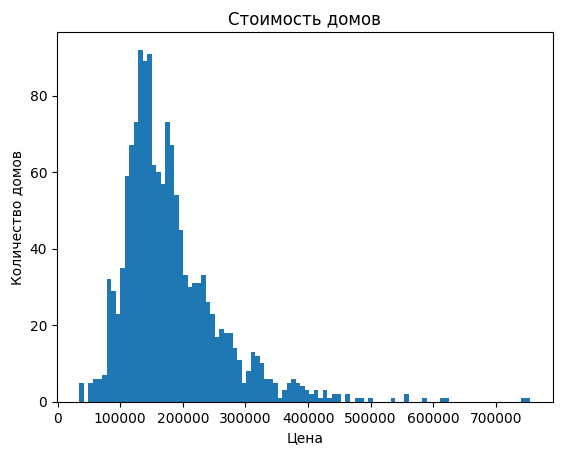

In [517]:
plt.hist(df2['SalePrice'], bins=100)
plt.title('Стоимость домов')
plt.xlabel('Цена')
plt.ylabel('Количество домов')

Распределение не нормальное

<Axes: xlabel='SalePrice'>

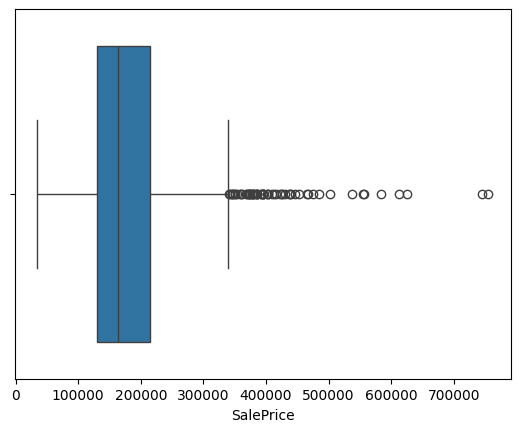

In [518]:

sns.boxplot(x=df2["SalePrice"])

Большое кол-во нарастающих выбрасов в переменной SalePrice со значения 350 000

<Axes: xlabel='OverallQual', ylabel='Count'>

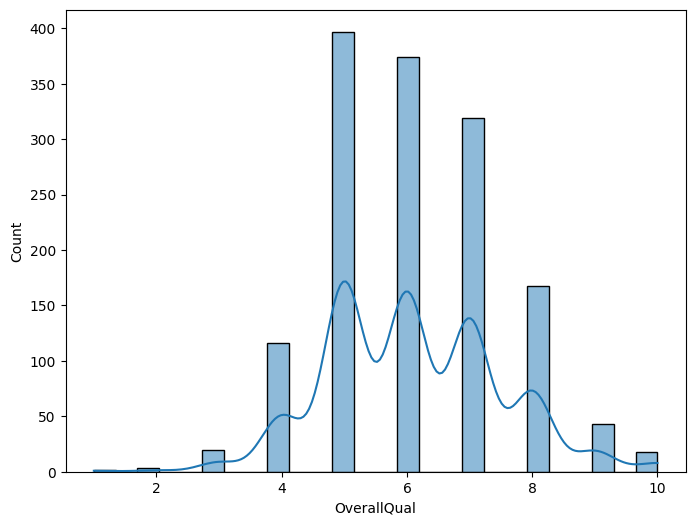

In [519]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['OverallQual'], kde=True)

<Axes: xlabel='GrLivArea', ylabel='Count'>

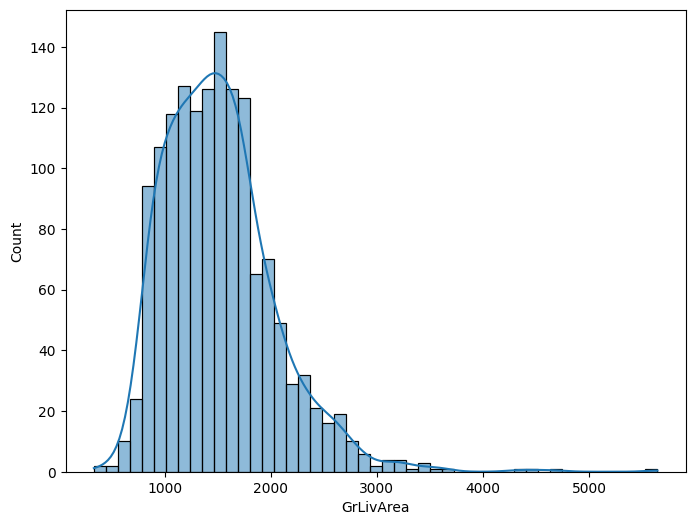

In [520]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['GrLivArea'], kde=True)

<Axes: xlabel='GarageCars', ylabel='Count'>

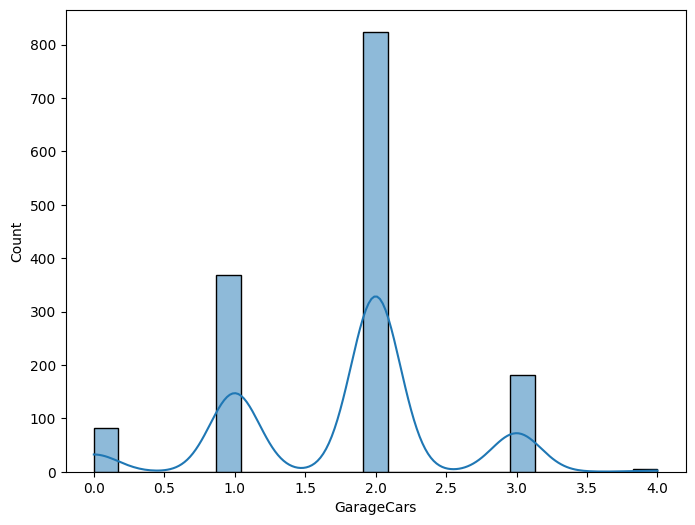

In [521]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['GarageCars'], kde=True)

In [522]:
impotant_variables = ['OverallQual', 'GrLivArea', 'GarageCars']

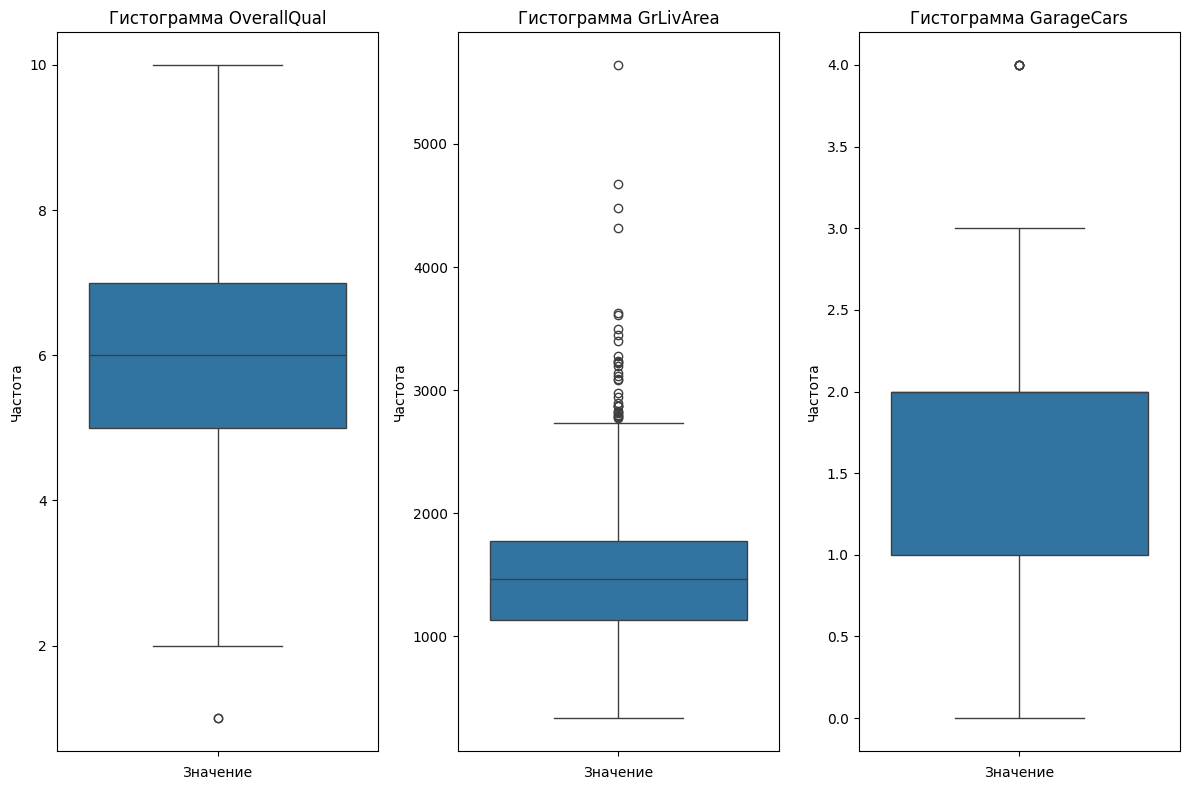

In [523]:
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.flatten()

for i, col in enumerate(impotant_variables):
    sns.boxplot(data=df, y = col, ax=axes[i])
    axes[i].set_title(f'Гистограмма {col}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Переменная GrLivArea содержит множественные выбросы, OverallQual только 1 выброс, GarageCars - выбросы отсутствуют

In [524]:
df_original = pd.DataFrame(df2)

In [525]:
corr_matrix = df_original[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']].corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix)<0.3] = 0
corr_matrix

,SalePrice,OverallQual,GrLivArea,GarageCars
SalePrice,1.0,0.8,0.7,0.6
OverallQual,0.8,1.0,0.6,0.6
GrLivArea,0.7,0.6,1.0,0.5
GarageCars,0.6,0.6,0.5,1.0


Text(0.5, 1.0, 'График корреляции')

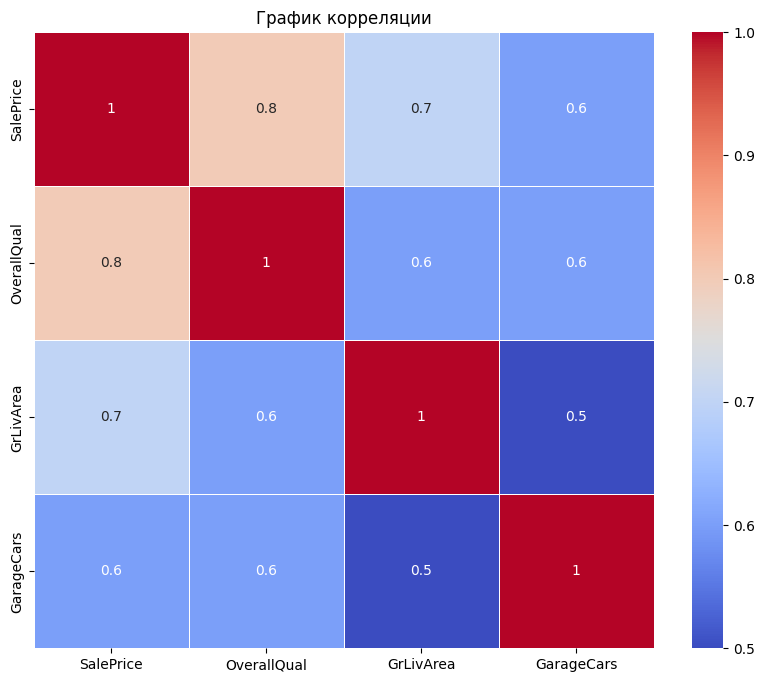

In [526]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('График корреляции')

Корреляция между ценой и качеством отделки составляет 0.8 – достаточно высокая корреляция,  чем лучше отделка, тем выше цена объекта.
Также заметная корреляция прослеживается между ценой и жилой площадью первого этажа 0.7, а также возможностью размещения максимального кол-ва машин в гараже 0.6

In [527]:
df_original['GarageCars'].max()

4

5. Выполните проектирование признаков путем реализации следующих преобразований: a. Работайте с категориальными переменными, применяя one-hot encoding или label encoding, в зависимости от характера переменной. b. При необходимости создайте новые характеристики, такие как общая площадь или возраст объекта недвижимости, путем объединения существующих характеристик.

In [528]:
# Проектирование переменных
# One-hot encoding
# data_encoded = pd.get_dummies(df, columns=['MSZoning'])

# Label encoding

le = LabelEncoder()
df_original['MSZoning_encoder'] = le.fit_transform(df_original['MSZoning'])
df_original['CentralAir_encoded'] = le.fit_transform(df_original['CentralAir'])

In [529]:
df_original['MSZoning_encoder'].describe()

count    1460.000000
mean        3.028767
std         0.632017
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: MSZoning_encoder, dtype: float64

In [530]:
df_original['CentralAir_encoded'].describe()

count    1460.000000
mean        0.934932
std         0.246731
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: CentralAir_encoded, dtype: float64

In [531]:
df_original = pd.get_dummies(df_original, columns = ['Street', 'LotShape', 'LandContour', 'Utilities'], 
                             prefix=['Street', 'Shape', 'Contour', 'Util'], dtype='int64')

In [532]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


6. Сохраните очищенный и преобразованный набор данных в новый CSV-файл под названием 'cleaned_house_prices.csv'.

In [533]:
df.to_csv('cleaned_house_prices.csv', encoding='utf-8')